## Summary of the results I've obtained so far

As initially proposed, tables were constructed in such a way that two elements X,Y appear in the same table only if there exist 2 compounds $A = R-X_n$ and $B = R-Y_n$, where if X were replaced by Y in compound A, the result would be compound B. This approximation ignores every structural factor and relies only on compositional data.

Note from this approach that n is an integer, that is, there's a problem when treating non-stoichiometric compounds. In the given dataset there are actually examples of such non-stoichiometric compounds, and so this case had to be handled properly, i.e., such compounds were removed from dataset.

In [1]:
from Analysis import *

## Load all the data that was produced with sparse_getTabs_v0.py  using dataset sample_clean.csv

`sparse_getTabs_v0.py` produced 3 files:
- `AllMatches.bin`: A list of lists as: [  [elem_list,years,IDs]  ]
      - ith list contains 3 lists: 
          - elem_list: list of elements that fit within ith formula R(n).
          - years: year of discovery of compound associated with each element above and ith R(n).
          - IDs:   ID of compound as above.
- `AllRs.npz`: Stores the corresponding R(n) for each list above.
- `ElementList.txt`: Element list found in dataset.

In [2]:
dataPath = "../Code/Data/"

# Load AllMatches.bin
Match_file = bz2.BZ2File(dataPath+'AllMatches.bin', 'r')
Matches = pickle.load(Match_file)

# Load AllRs.npz
Rs = sp.load_npz(dataPath+'AllRs_clean_sparse.npz')

print(Rs.shape)
# Load element list
elemList = []
with open(f"{dataPath}/ElementList.txt",'r') as f:
    for line in f:
        elemList.append(line.strip())
        
print(elemList[:10])

(6114, 61)
['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C']


### Convert element lists into np.arrays by using loaded PT.

Create an ID-->year mapping. Then create arrays for ID (using elem_list for position) and then map into years.

That way you get the two arrays as usual.

In [3]:
%%time

Tids = -np.ones((len(Matches),7,32))     # This gets the arrays filled with IDs
Tyr = -np.ones((len(Matches),7,32))      # This gets the arrays filled with years
for i,match in enumerate(Matches):
    getTable(TP, match[0], match[2], Tids[i])  # Match[2] to fill with IDs
    getTable(TP, match[0], match[1], Tyr[i] )  # Match[1] to fill with years

CPU times: user 26.1 ms, sys: 11.6 ms, total: 37.7 ms
Wall time: 38.2 ms


---

## The idea of having both tables filled with substance ID and years is to have different query methods.

1. For instance, we might be interested only in substances discovered before 1939. In that case we can do `t = (Tyr < 1939) & (Tyr > 0)*1` and that gets you an array t with 1s and 0s, meaning the same (simpler) thing discussed before.

2. Or you may be interested in checking in which tables a particular compound occurs. For instance, what tables does H2O appear in? Then query by substance ID!

In [4]:
def getFormula(R,elemList):
    """Convert R sparse vector into string composition:
    sparse([0,1,0,...,4,6]) --> Ti4X6 for instance """

    form = ''
    for ind,n in zip(R.indices[:-1],R.data[:-1]):
        form += elemList[ind] 
        if n != 1:
            form += str(int(n))
    return form + f'X{int(R.data[-1]) if R.data[-1]!=1 else ""}'

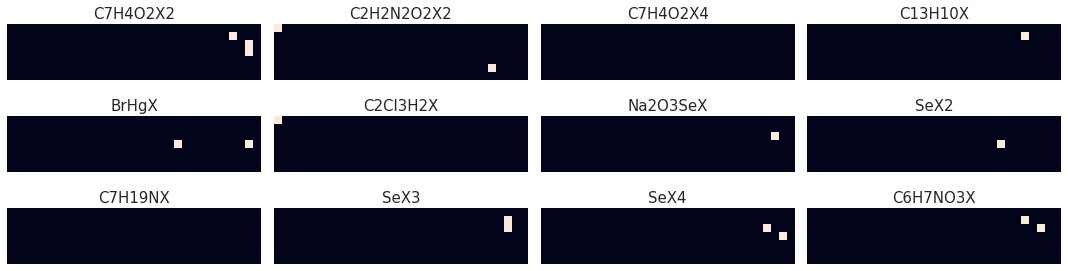

In [5]:
# Let's select all compounds discovered before 1850 (that's everything with this toy dataset)
t = (Tyr < 1850) & (Tyr > 0)*1

N = 3
fig = plt.figure(figsize=(15,1.4*N))
for i in range(4*N):
    ax = fig.add_subplot(N,4,i+1)
    ax.set_title(getFormula(Rs[i],elemList),fontsize=15)
    ax.imshow(t[i])
    ax.axis('off')
plt.tight_layout()

#plt.savefig('/home/andres/Schreibtisch/GR/work/inf/tables.png',dpi=300)

### Second case, you want to look for a particular compound.

In that case, get only tables where this compound exists. For instance, ID for H$_2$O is 2965.
Use `indexs = np.nonzero((ID==2965).sum(axis=(1,2)))[0]` to get the indices of the tables where this compound exists, then index and get to 1s and 0s with `new_t = (ID[idx]>1)*1`. You obviously need to index the R vector as well if you intend to use it for visualization `new_r = r[idx]`.

- Note that some substances are repeated in DS, so you'd have to look up for the many different IDs a single substance may have.

---

As you can see below, naturally H2O appears only in three tables, as that is all this formula allows due to its only 3 atoms.

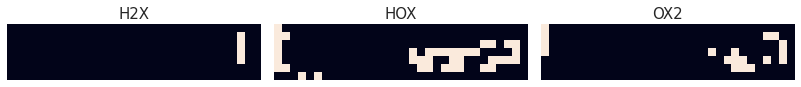

In [6]:
subsID = 2965
idx = np.nonzero((Tids==subsID).sum(axis=(1,2)))[0]

new_t = (Tids[idx]>1)*1
new_r = Rs[idx]

N = 1
fig = plt.figure(figsize=(15,5))
for i in range(3*N):
    ax = fig.add_subplot(N,4,i+1)
    ax.set_title(getFormula(new_r[i],elemList),fontsize=15)
    ax.imshow(new_t[i])
    ax.axis('off')
plt.tight_layout()

In [7]:
def findRns_withConds(Rs,Ts,formula,allOtherZero=True,n=False):
    """Finds all pairs (R,n) that fulfill certain conditions
    Rs is the list of (R,n) vectors where to look up
    Ts is the list of tables corresponding to these (R,n) pairs
    formula is any composition to look for inside any R. 
        For instance formula = 'Cl3Si' forces to look for Rs where there are only 3 Cl and 1 Si
    n is the X subindex. If set to False, then any n is posible
    allOtherZero is True if we want to look up for Rs where only the aforementioned elements are present
        if we're open to other possibilities, then False
        
    Returns: the pairs (R,n) fulfilling the conditions and their corresponding tables
    """
    ## Convert given formula into conditions
    Li = re.split(r"(?<!^)(?=[A-Z])",formula)  #Split as ['H2','O']
    li = [re.split(r"([A-z]+)(([0-9]*[.])?[0-9]+)",i)
          if bool(re.match(r'[A-z]*([0-9]*[.])?[0-9]+',i))
          else re.split(r"([A-z]+)(([0-9]*[.])?[0-9]+)",i+'1') for i in Li]  
    elems  = [i[1] for i in li]  # Index of element i to put correspondent data
    subin = [int(i[2]) for i in li]           # Num. atoms of element i
    
    if n: condition = (Rs.toarray()[:,-1]==n)   # Fix choice of n
    else: condition = True            # Otherwise any choice is ok

    suma = 0
    for elem,N in zip(elems,subin):
        condition = condition & (Rs[:,elemList.index(elem)].toarray()==N).flatten()  # Apply each condition 
        suma += N

    # Condition for looking only for exactly the inputed composition
    if allOtherZero:   condition = condition & (Rs[:,:-1].toarray().sum(axis=1)==suma) 

    if not condition.any():
        print('No (R,n)s where found that meet the provided conditions')
        return 0
    
    # Make query
    selectedRs = Rs[condition]
    selectedTs = Ts[condition]

    for R in selectedRs:
        print(getFormula(R,elemList))
        
    return selectedRs,selectedTs

In [8]:
# Example: Find all Rs containing exactly 3 Cl, 2 C and 1 O (and anything else)
formula = 'Cl3C2'
print("Example:\nFind all Rs containing exactly 3 Cl, 2 C and 1 O\n")
print("\t- And anything else, with any n for X:\n")
_ = findRns_withConds(Rs,Tids,formula,False)
print("\n\t- And anything else, but n for X == 2:")
_ = findRns_withConds(Rs,Tids,formula,False,2)
print("\n\t- And NOTHING else (except for X), with any n:")
_ = findRns_withConds(Rs,Tids,formula,True)

Example:
Find all Rs containing exactly 3 Cl, 2 C and 1 O

	- And anything else, with any n for X:

C2Cl3H2X
C2Cl3H2OX
C2Cl3HNOX
C2Cl3HO2X2
C2Cl3HX2
C2Cl3H3OX
C2Cl3OX
C2Cl3X3
C2Cl3X

	- And anything else, but n for X == 2:
C2Cl3HO2X2
C2Cl3HX2

	- And NOTHING else (except for X), with any n:
C2Cl3X3
C2Cl3X


Cl3SiX


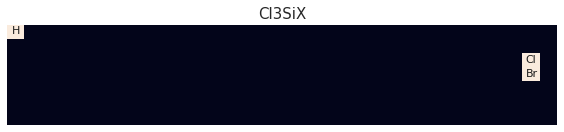

In [9]:
ra,ta = findRns_withConds(Rs,Tids,'Cl3Si',True,1)

N = 1
fig,ax = plt.subplots(figsize=(8,2))
ax.set_title(getFormula(ra[0],elemList),fontsize=15)
sns.heatmap(ta[0]>0,cbar=False)
ax.axis('off')

putLabelsInTables(ta[0],ax)
    
plt.tight_layout()

#plt.savefig('/home/andres/Schreibtisch/GR/work/inf/tableCl3SiX.png',dpi=300)

Cl4X


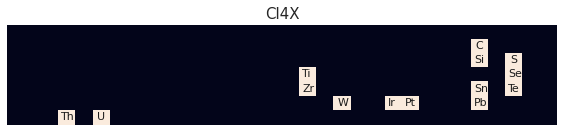

In [10]:
ra,ta = findRns_withConds(Rs,Tids, 'Cl4',True,1)

N = 1
fig,ax = plt.subplots(figsize=(8,2))
ax.set_title(getFormula(ra[0],elemList),fontsize=15)
sns.heatmap(ta[0]>0,cbar=False)
ax.axis('off')

putLabelsInTables(ta[0],ax)

plt.tight_layout()

#plt.savefig('/home/andres/Schreibtisch/GR/work/inf/tableCl4X.png',dpi=300,bbox_inches='tight')

## Calculate some descriptive statistics on the data obtained:

- Mean vertical, horizontal, and euclidean distance between elements in a same table. For a "good" periodic system all these quantities are expected to be minimum.

In [12]:
%%timeit
dis,norm = meanDist(Matches,2100)

216 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## The plots below show different mean distances from one element to the others in the same table.

- For instance, if one table contains only H and Na, then Horizontal distance = 0 (as they are located in the same group), Vertical distance = 2 (as Na is 2 periods above H) and euclidean distance is = 2 as well.

We do this for each element present in each table and calculate a mean among tables.

The PT plots should be self-explanatory, however the boxplots are made so that also other quantities such as median and outliers are visualized.

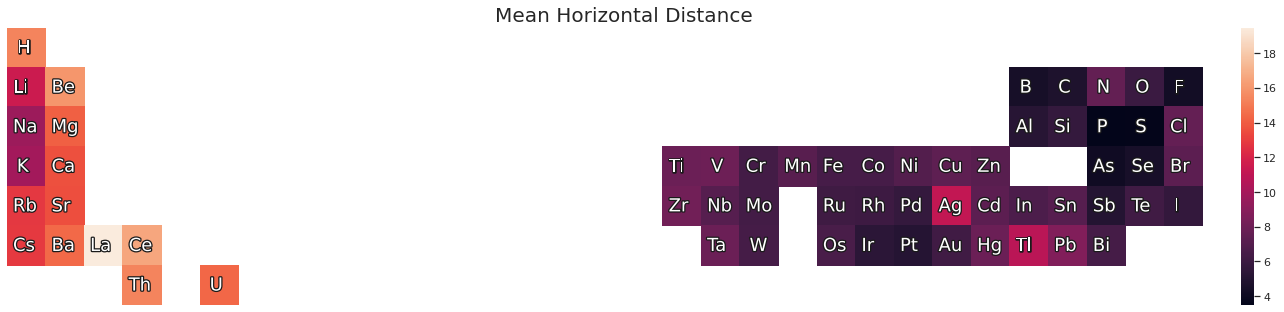

In [13]:
# See results with all data
dis,norm = meanDist(Matches,2100)
vert,hori = dis

makeTPPlot(hori,norm,title="Mean Horizontal Distance",PT=TP,fs=18)

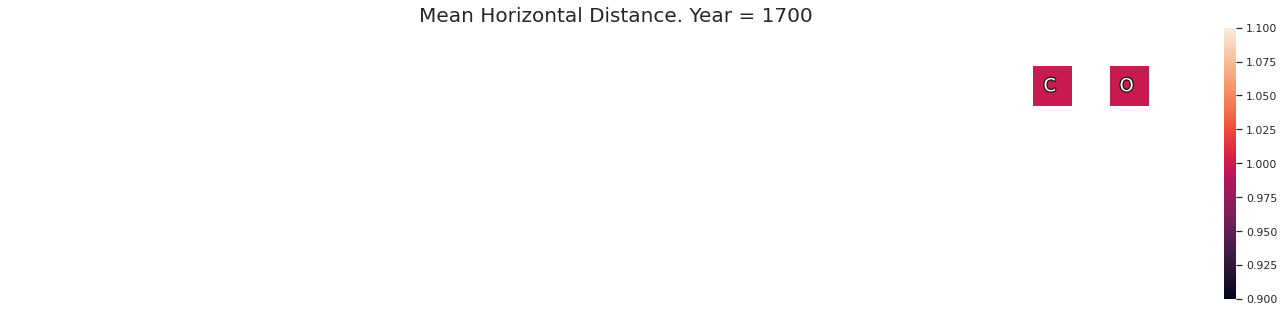

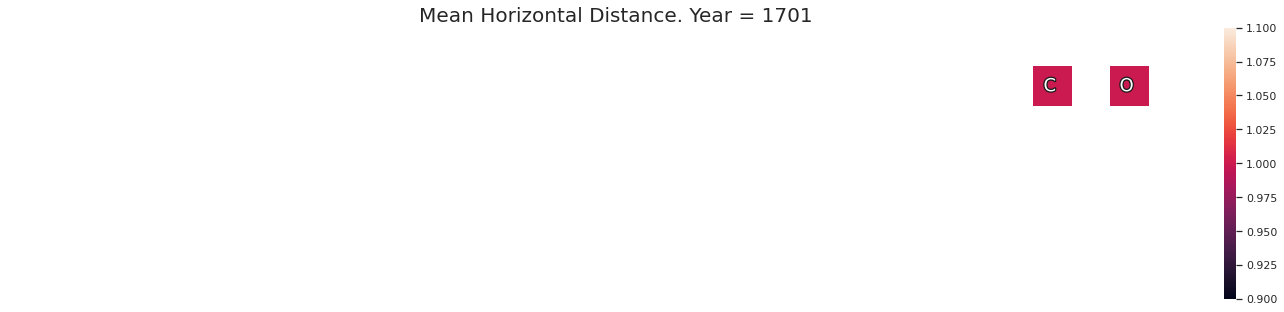

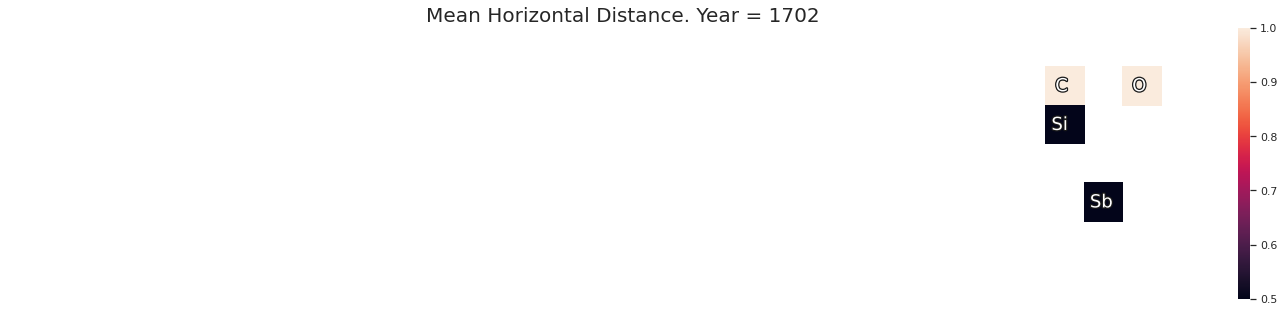

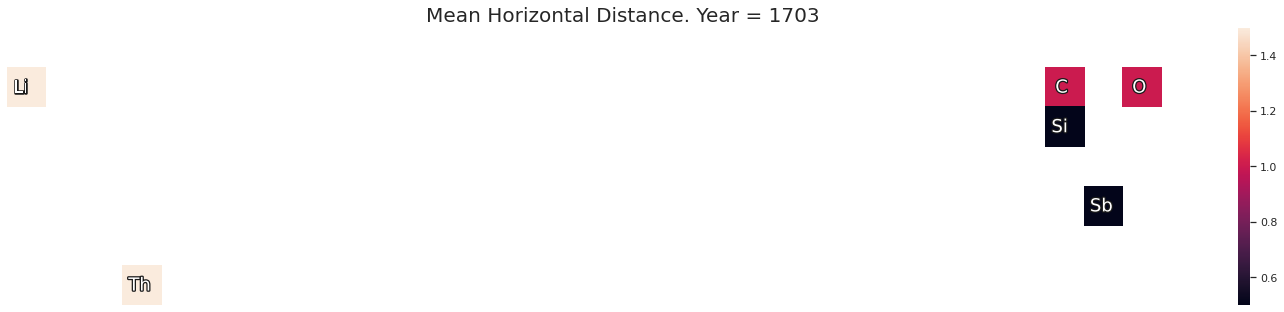

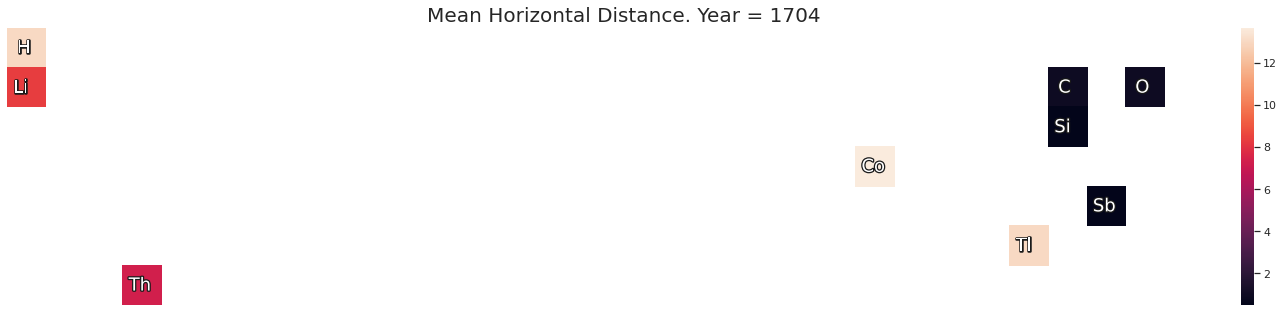

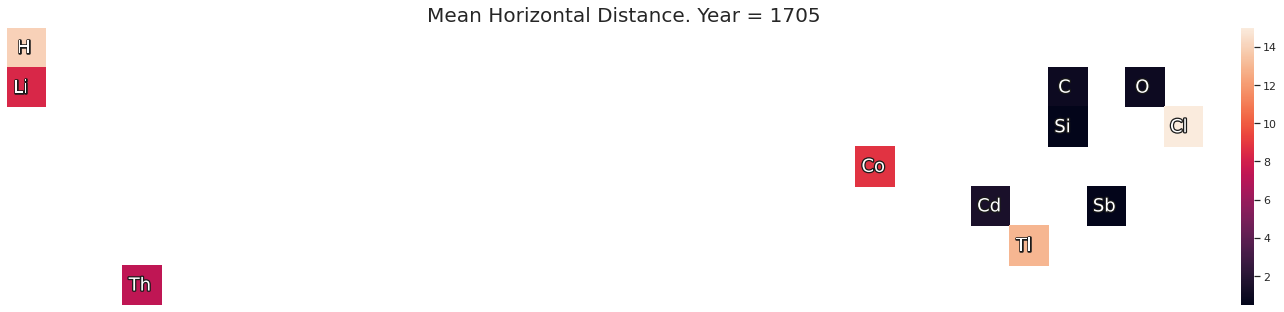

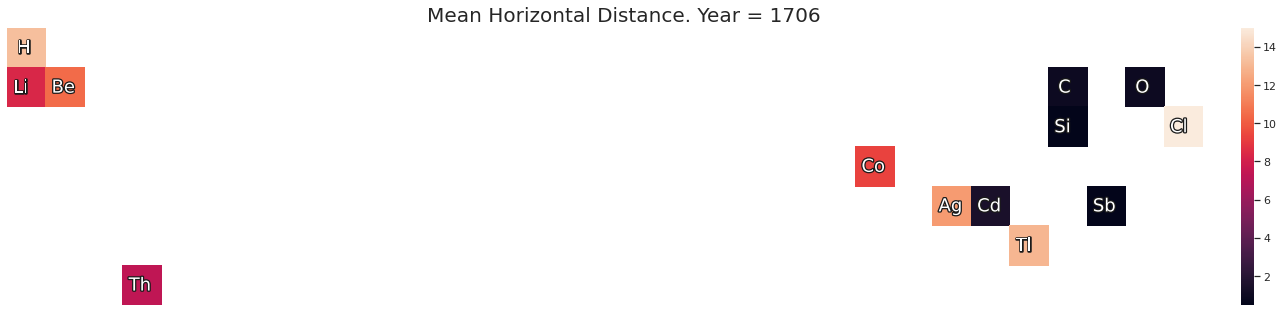

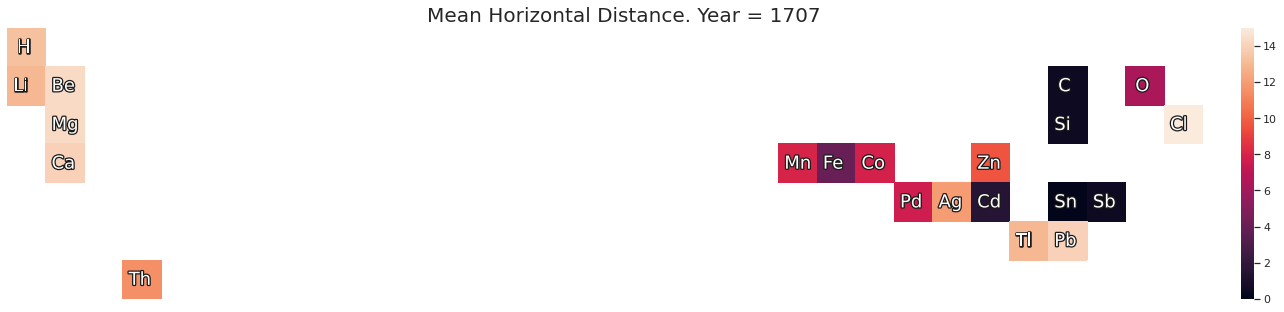

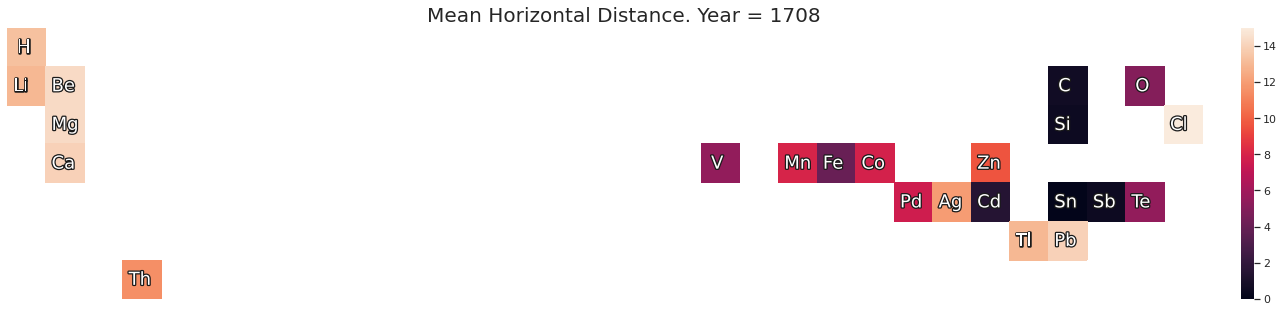

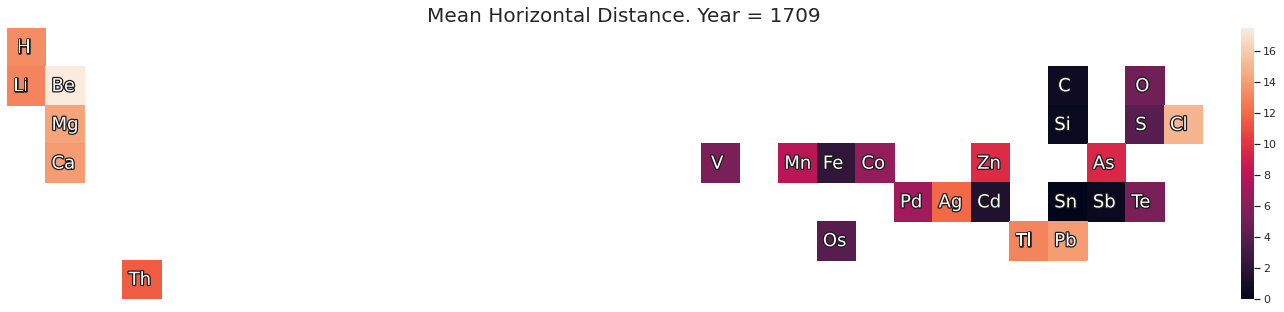

In [14]:
# Explore time variations
for i in range(1700,1710):
    dis,norm = meanDist(Matches,i)
    vert,hori = dis
    
    makeTPPlot(hori,norm,title=f"Mean Horizontal Distance. Year = {i}",PT=TP,fs=18)

In [ ]:
# Make a boxplot here

## The most significant measure of 'fitness' of a PT is Horizontal distance.

This variable measures by what amount are similar elements in nearby columns, which is pretty much the idea of the original periodic table. 

The other measures are not in principle so important as vertical separation is mainly defined by order relationships, that is, as much as H is similar to Cs, Cs's atomic mass is much greater than H's.

--- 
## Let's now see what are the 'most similar' elements for each element.
 That is, find what elements share the most molecular fragments with a given element.

In [225]:
from matplotlib.gridspec import GridSpec

def mostSimElems(T,element,save=False,TP=TP):
    """Plot a map and a barplot of the most similar elements for the given element
    based on 'replaceability' in chemical formulas"""

    X,Y = TP[element]
    img = T[T[:,X,Y]>0].sum(axis=0).copy()*1

    mask = img!=0
    with np.errstate(invalid='ignore',divide='ignore'):
        img = img/mask  #Convert zeros to NaNs so image only shows elements
        img[X,Y] = np.nan   #Don't plot element, only every other element

    # Delete all empty entries (all nan)
    data_bar = {}
    # Extract distance data for every element
    for el in TP.keys():
        x,y=TP[el]
        dt_i = img[x,y]
        if not np.isnan(dt_i): 
            data_bar[el] = dt_i

    # Plot similarity PT for elem
    fig = plt.figure(figsize=(18,7))
    gs = fig.add_gridspec(2,2,  width_ratios=(99, 1), height_ratios=(6, 4),
                  #    left=0, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0.2)

    ax = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, :])
    cbar = fig.add_subplot(gs[0,1])
    
    cmap = sns.color_palette("magma", as_cmap=True)
    sns.heatmap(img,ax=ax,cbar_ax=cbar,
                vmin=0,vmax=np.nanmax(img),
                cmap=cmap)
    
    ax.set_title(f'Replaceability of {element} in chemical formulas', fontsize=20)
    
    ax.axis('off')
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    #ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    
    # Plot barplot
    df = (pd.Series(data_bar)
          .reset_index()
          .rename(columns={'index':'Element',
                           0:'Occurences'}))

    df['color'] = (df['Occurences']/df['Occurences'].max()).apply(cmap)
    ax1.bar(x=range(df.shape[0]) ,
            height=df['Occurences'],
            color=df['color'],edgecolor = "k")
    
    ax1.set_xticks(range(df.shape[0]))
    ax1.set_xticklabels(df['Element'])
    ax1.set_xlim(-1,df.shape[0])
    
    # Put the element's symbol at it's position
    if len(element)==1:  tab = 0.2
    else:                tab = 0.02
    ax.text(Y+tab,X+0.7,element,fontsize=17) 
    
    if save: plt.savefig(save,dpi=300,bbox_inches='tight')

## Let's make these plots for some elements and see what's interesting

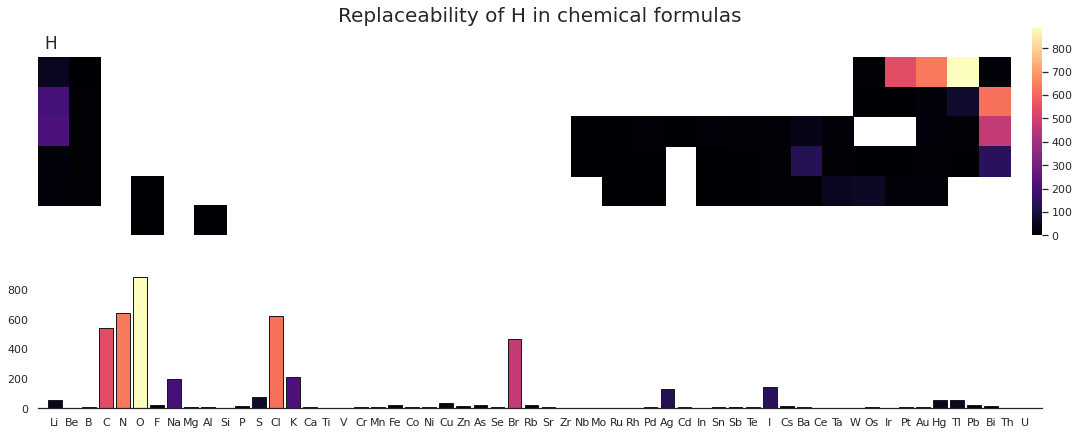

In [226]:
mostSimElems(Tids>0,'H')#,save='/home/andres/Schreibtisch/GR/work/inf/replace_H.png')

### There are some interesting results we can further explore here:

For instance, in the H plot we see: 
- The most 'similar' elements are the halogens (except F) 
- and the first period of the p-block elements (C,N,O)
- Others like alkaline metals have much lower counts, while this would be expected for them to be higher (as H is in group 1).

#### Let's explore which compounds in particular are responsible for such a behaviour.

In [220]:
def showCommonOccurences(elem1,elem2,maxNum):
    """Show which compounds exist in which elem1 and elem2 can be replaceable"""
    x,y =   TP[elem1]
    x1,y1 = TP[elem2]

    common = (Tids[:,x,y]>0) & (Tids[:,x1,y1]>0)
    print(f"Number of common occurences: {common.sum()}\n")
    print(f"X = ({elem1}, {elem2}) \n")

    for i in Rs[common][:maxNum]:
        print(getFormula(i,elemList))

In [221]:
showCommonOccurences('H','O',20)

Number of common occurences: 887

X = (H, O) 

C7H4O2X4
SeX2
C4HN4PtX
BrC4H3X4
C6H4O2X4
C12H8N2OX2
C14H4N4O4X8
C9H10N2O2X2
C16H14O3X2
Br3C7H5N2X2
C9H12N2X2
C2HO2RbX2
X
C7ClH5X2
C5H4O2X2
C12H16O2X6
C8ClH7OX2
C4H4O2X2
C4H4O2X4
C6H8O4X2


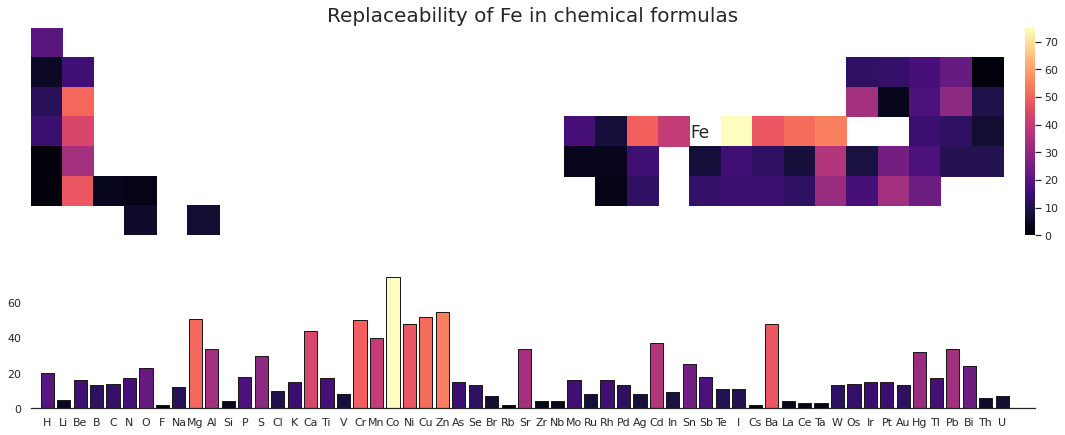

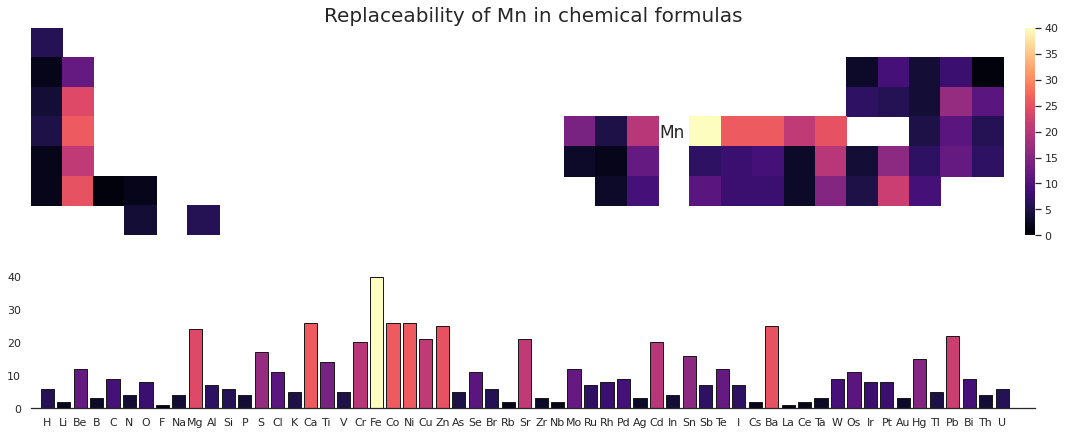

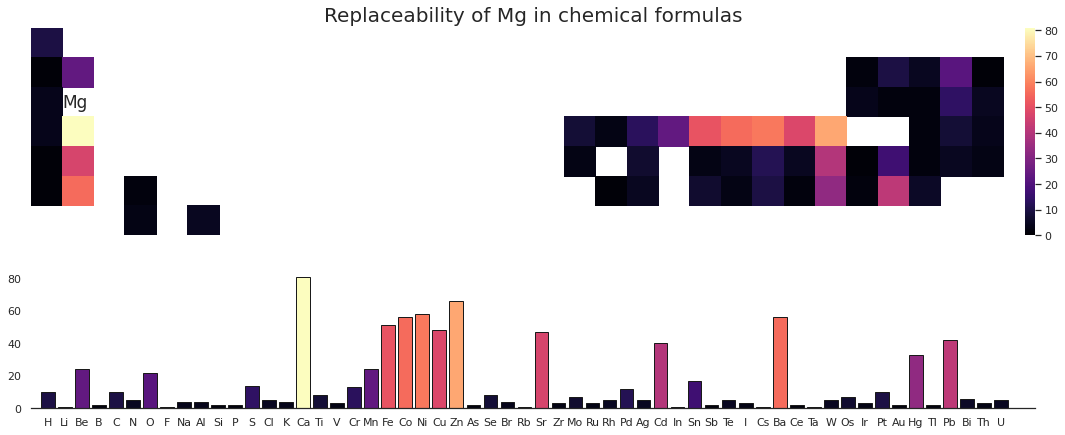

In [223]:
mostSimElems(Tids>0,'Fe')#,save='/home/andres/Schreibtisch/GR/work/inf/replace_Fe.png')
mostSimElems(Tids>0,'Mn')
mostSimElems(Tids>0,'Mg')

## Another interesting finding (from the Fe plots) is that alkaline earth metals and period 4 transition metals seem to form a separate group.

This *may* be a well known fact, but I actually didn't know this. It is interesting as it raises the questions: 

- Could the PT be organized in such a way that the elements of this "group" are closer to each other? If so, which is better? 
- Why did the PT wasn't conceived this way as opposed to the form we know?

The results from these plots are interesting as they imply that in transition metals the similarities are more horizontal than vertical. 

For instance, 5 and 6 period transition metals are not much brighter than for instance p-block or group 1 elements.

---
### Let's now look at 5 and 6 period transition metals and see if the above observations still hold.

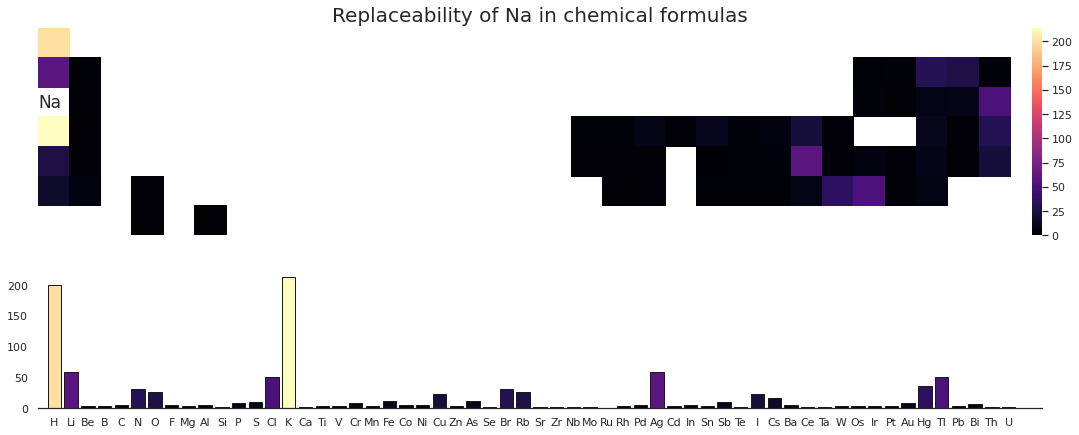

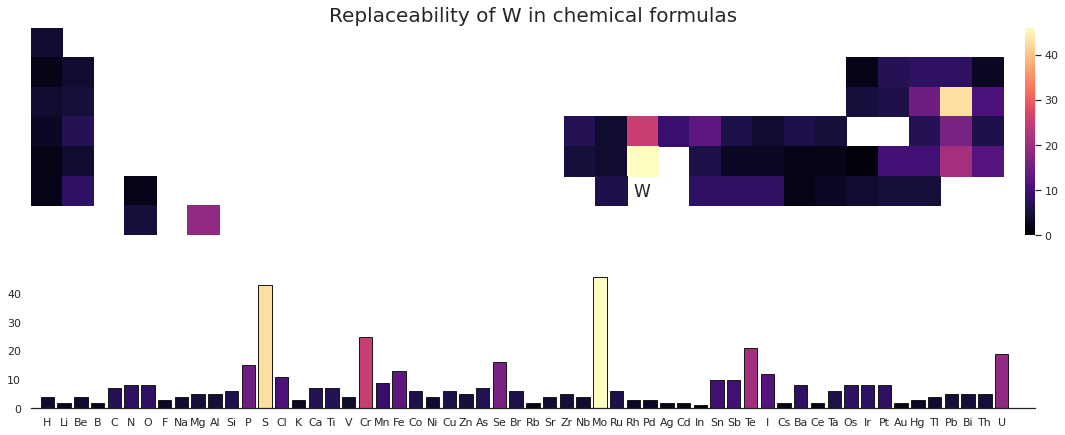

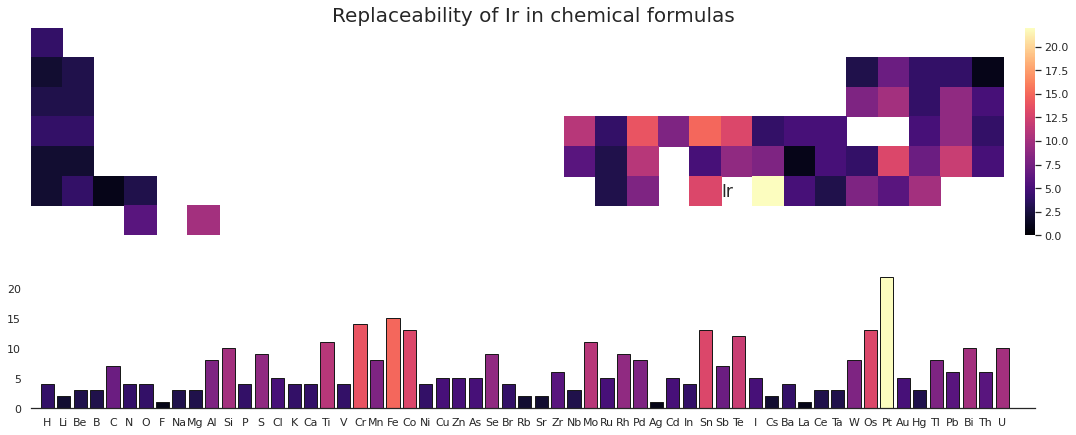

In [224]:
mostSimElems(Tids>0,'Na')
mostSimElems(Tids>0,'W')
mostSimElems(Tids>0,'Ir')

In this case a similar pattern is actually observed: the brighter elements are those (some) of period 4 + group 12 transition metals in the case of Pd. 

In the case of Pd and W we can also see that vertical similarities are also important: for both of these, the brighter element is that below or above. 

### There is probably some substructure in period 5 and 6 transition metals: here vertical similarities are important as well.

---

All of this is subjected to the inevitable possibility that the chemistry of these elements hadn't been as extensively explored as that of others. In that scenario, some underlying structures are likely to be obfuscated by more visually obvious results due to the undersampling of combinations and/or use of chemical elements at the time.

An example of this would be: there actually exist a vertical structure within all transition metals, however overexploration of the chemistry of period 4 transition metals may have obfuscated such a structure.

### All of this should be properly tested.
---

#### All of the results can be easily visualized in a matrix (similar to a correlation matrix)

In [276]:
def mostSimElems_Data(T,element):
    """Plot a map and a barplot of the most similar elements for the given element
    based on 'replaceability' in chemical formulas"""

    x,y = TP[element]
    img = T[T[:,x,y]>0].sum(axis=0).copy()

    mask = img!=0
    with np.errstate(invalid='ignore',divide='ignore'):
        img = img/mask  #Convert zeros to NaNs so image only shows elements
    
    img = img/img[x,y]  # Normalize by number of appearances of element in DS

    # Delete all empty entries (all nan)
    data_bar = {}
    # Extract distance data for every element
    for el in TP.keys():
        x,y=TP[el]
        dt_i = img[x,y]
        if el in elemList:#not np.isnan(dt_i): 
            data_bar[el] = dt_i
            
    df = (pd.Series(data_bar)
          .rename(element) )   
    
    return df

In [277]:
mostSimElems_Data(Tids>0,'H')

H     1.000000
Li    0.019175
Be    0.001809
B     0.002894
C     0.196093
N     0.231187
O     0.320912
F     0.006874
Na    0.072359
Mg    0.003618
Al    0.002171
Si    0.000724
P     0.006512
S     0.026411
Cl    0.225398
K     0.077062
Ca    0.003256
Ti    0.001085
V     0.001447
Cr    0.004342
Mn    0.002171
Fe    0.007236
Co    0.003256
Ni    0.003980
Cu    0.014110
Zn    0.004703
As    0.007598
Se    0.003256
Br    0.169320
Rb    0.007598
Sr    0.002533
Zr    0.000724
Nb    0.000724
Mo    0.001447
Ru    0.000362
Rh    0.001809
Pd    0.002894
Ag    0.047395
Cd    0.002894
In    0.001809
Sn    0.002171
Sb    0.003256
Te    0.002171
I     0.052460
Cs    0.005789
Ba    0.002894
La         NaN
Ce    0.000362
Ta    0.000724
W     0.001447
Os    0.002171
Ir    0.001447
Pt    0.002894
Au    0.003256
Hg    0.019175
Tl    0.021346
Pb    0.006874
Bi    0.005065
Th    0.000724
U     0.001085
Name: H, dtype: float64

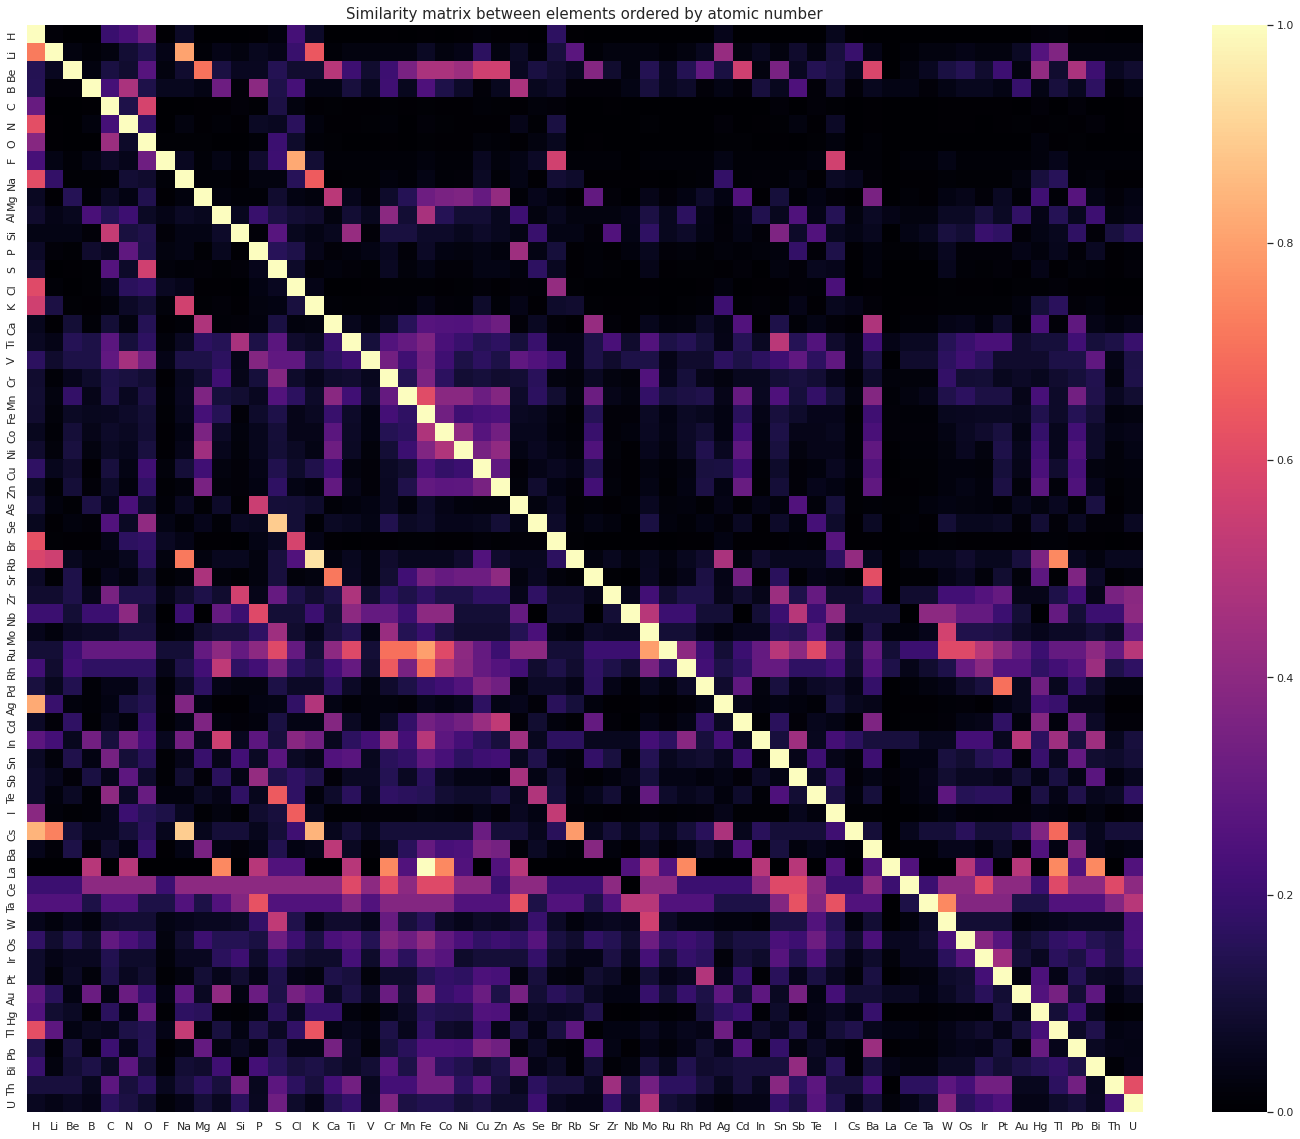

In [280]:
matrix = pd.DataFrame([])

# Element list ordered by atomic number
elemList_AN = [e for e in TP.keys() if e in elemList]

for elem in elemList_AN:
    matrix = pd.concat([matrix,mostSimElems_Data(Tids>0,elem)],axis=1)
    
matrix = matrix.fillna(0.)

fig,ax = plt.subplots(figsize=(25,20))
ax.set_title("Similarity matrix between elements ordered by atomic number",fontsize=15)
sns.heatmap(matrix.T,ax=ax,
            cmap=sns.color_palette("magma", as_cmap=True))

#plt.savefig('/home/andres/Schreibtisch/GR/work/inf/matrix.png',
#            dpi=400,bbox_inches='tight')
plt.show()

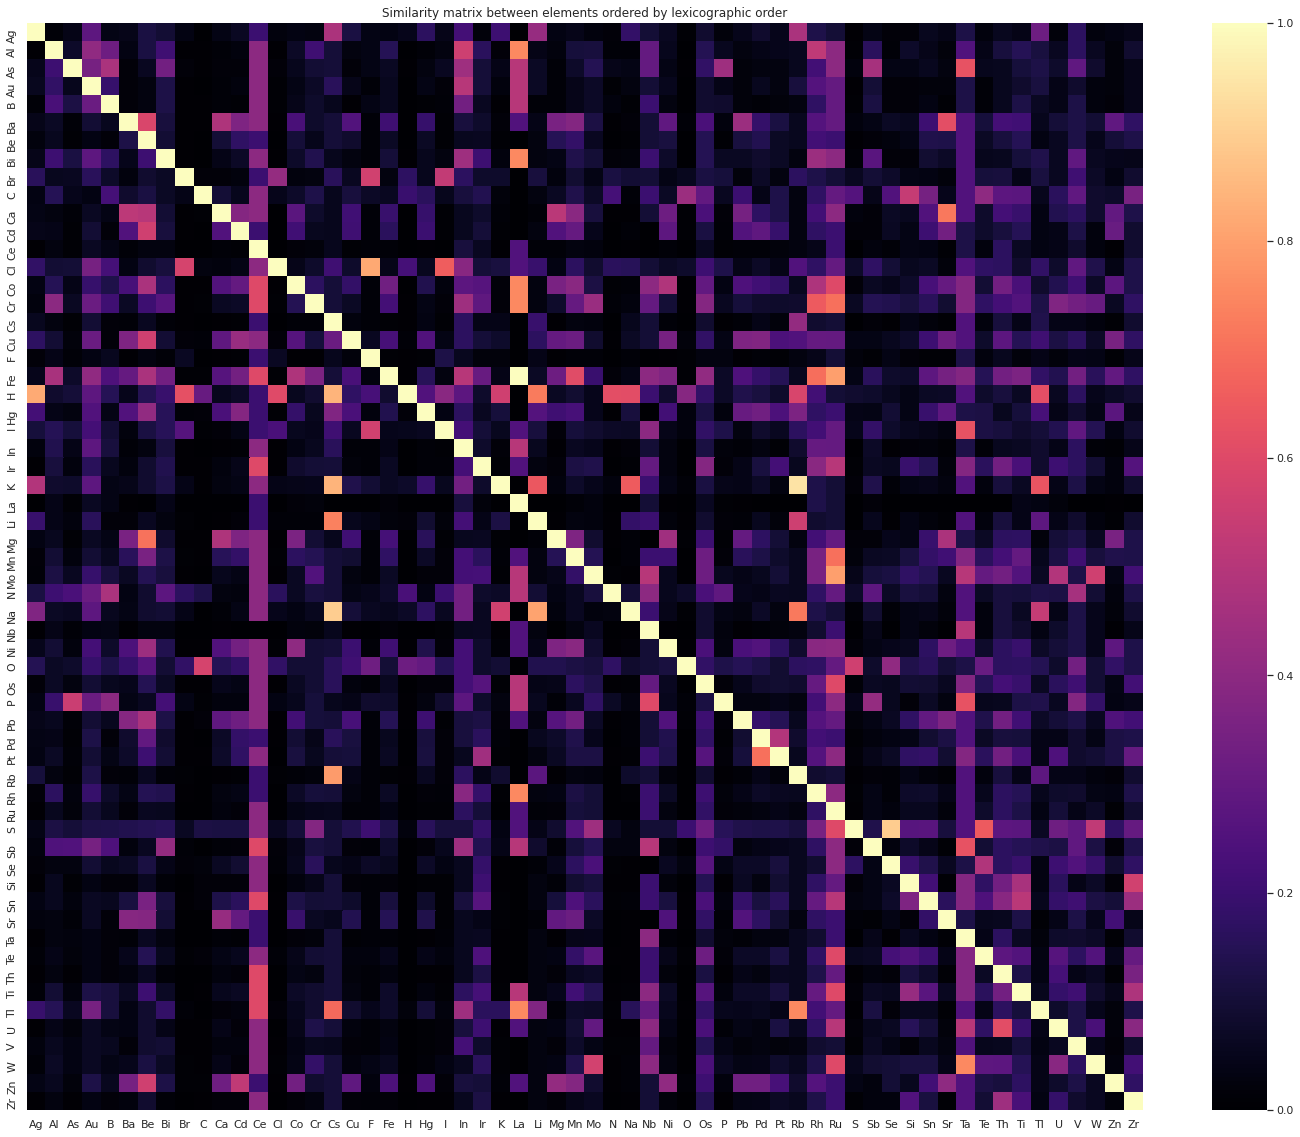

In [281]:
matrix = pd.DataFrame([])

for elem in elemList:
    matrix = pd.concat([matrix,mostSimElems_Data(Tids>0,elem)],axis=1)
    
matrix = matrix.fillna(0.)
# Use same order as in rows, ordered by lexicographic order (random then)
matrix = matrix.T.loc[:,matrix.columns]  

fig,ax = plt.subplots(figsize=(25,20))

ax.set_title("Similarity matrix between elements ordered by lexicographic order")
sns.heatmap(matrix.T,ax=ax,
           cmap=sns.color_palette("magma", as_cmap=True))
plt.show()

### Note: This matrix is not symmetric due to the way the rows were normalized.

Be careful and aware of this fact as this may lead to misunderstandings or wrong conclusions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# The objective of this notebook is to translate the data between periodic systems.

That is, given two different periodic systems, we want to have the data in both formats without having to perform the whole preprocessing using the new PS

In [2]:
t1 = np.load("Data/R_Tables_P0.npy")
t2 = np.load("Data/R_Tables_P1.npy")
t3 = np.load("Data/R_Tables_P2.npy")

t = np.concatenate([t1,t2,t3],axis=0)
print(t.shape)

(6145, 7, 32)


## This is how the data look represented on this chosen PT (Mendeleev's). We could, for many reasons, test different PTs to represent the same data.

### There is no need to run again the whole data production program, instead we ought to translate the data.

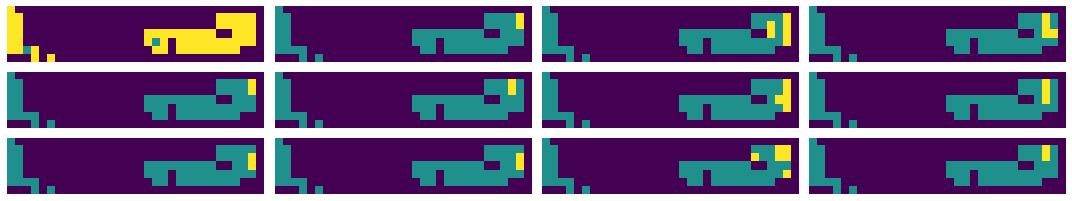

In [6]:
N = 3
fig = plt.figure(figsize=(15,3))
for i in range(4*N):
    ax = fig.add_subplot(N,4,i+1)
    ax.imshow(t[i])
    ax.axis('off')
plt.tight_layout()

In [218]:
def getRandPT(TP):
    """Generate random PTs as example"""
    elems = TP.keys()

    rows,cols = np.meshgrid(np.arange(6),np.arange(32))
    posit = np.stack([rows,cols]).reshape(2,-1)   #All possible positions, as (x,y) pairs
    #Do random index permutation and pick only len(elems) first
    rndn = np.random.permutation(posit.shape[1])[:len(elems)]  
    posit = posit[:,rndn].T   #Shuffle elements

    # Create a dict: final PT
    return dict(zip(elems,posit))
    
def translate(data,PT1,PT2):
    """Translate data from PT1 to PT2"""
    newTP = data.copy()*0.0 - 1.

    for elem in PT1.keys():
        x2,y2 = PT2[elem]
        x1,y1 = PT1[elem]
        
        newTP[:,x2,y2] = data[:,x1,y1].copy()
        
    return newTP

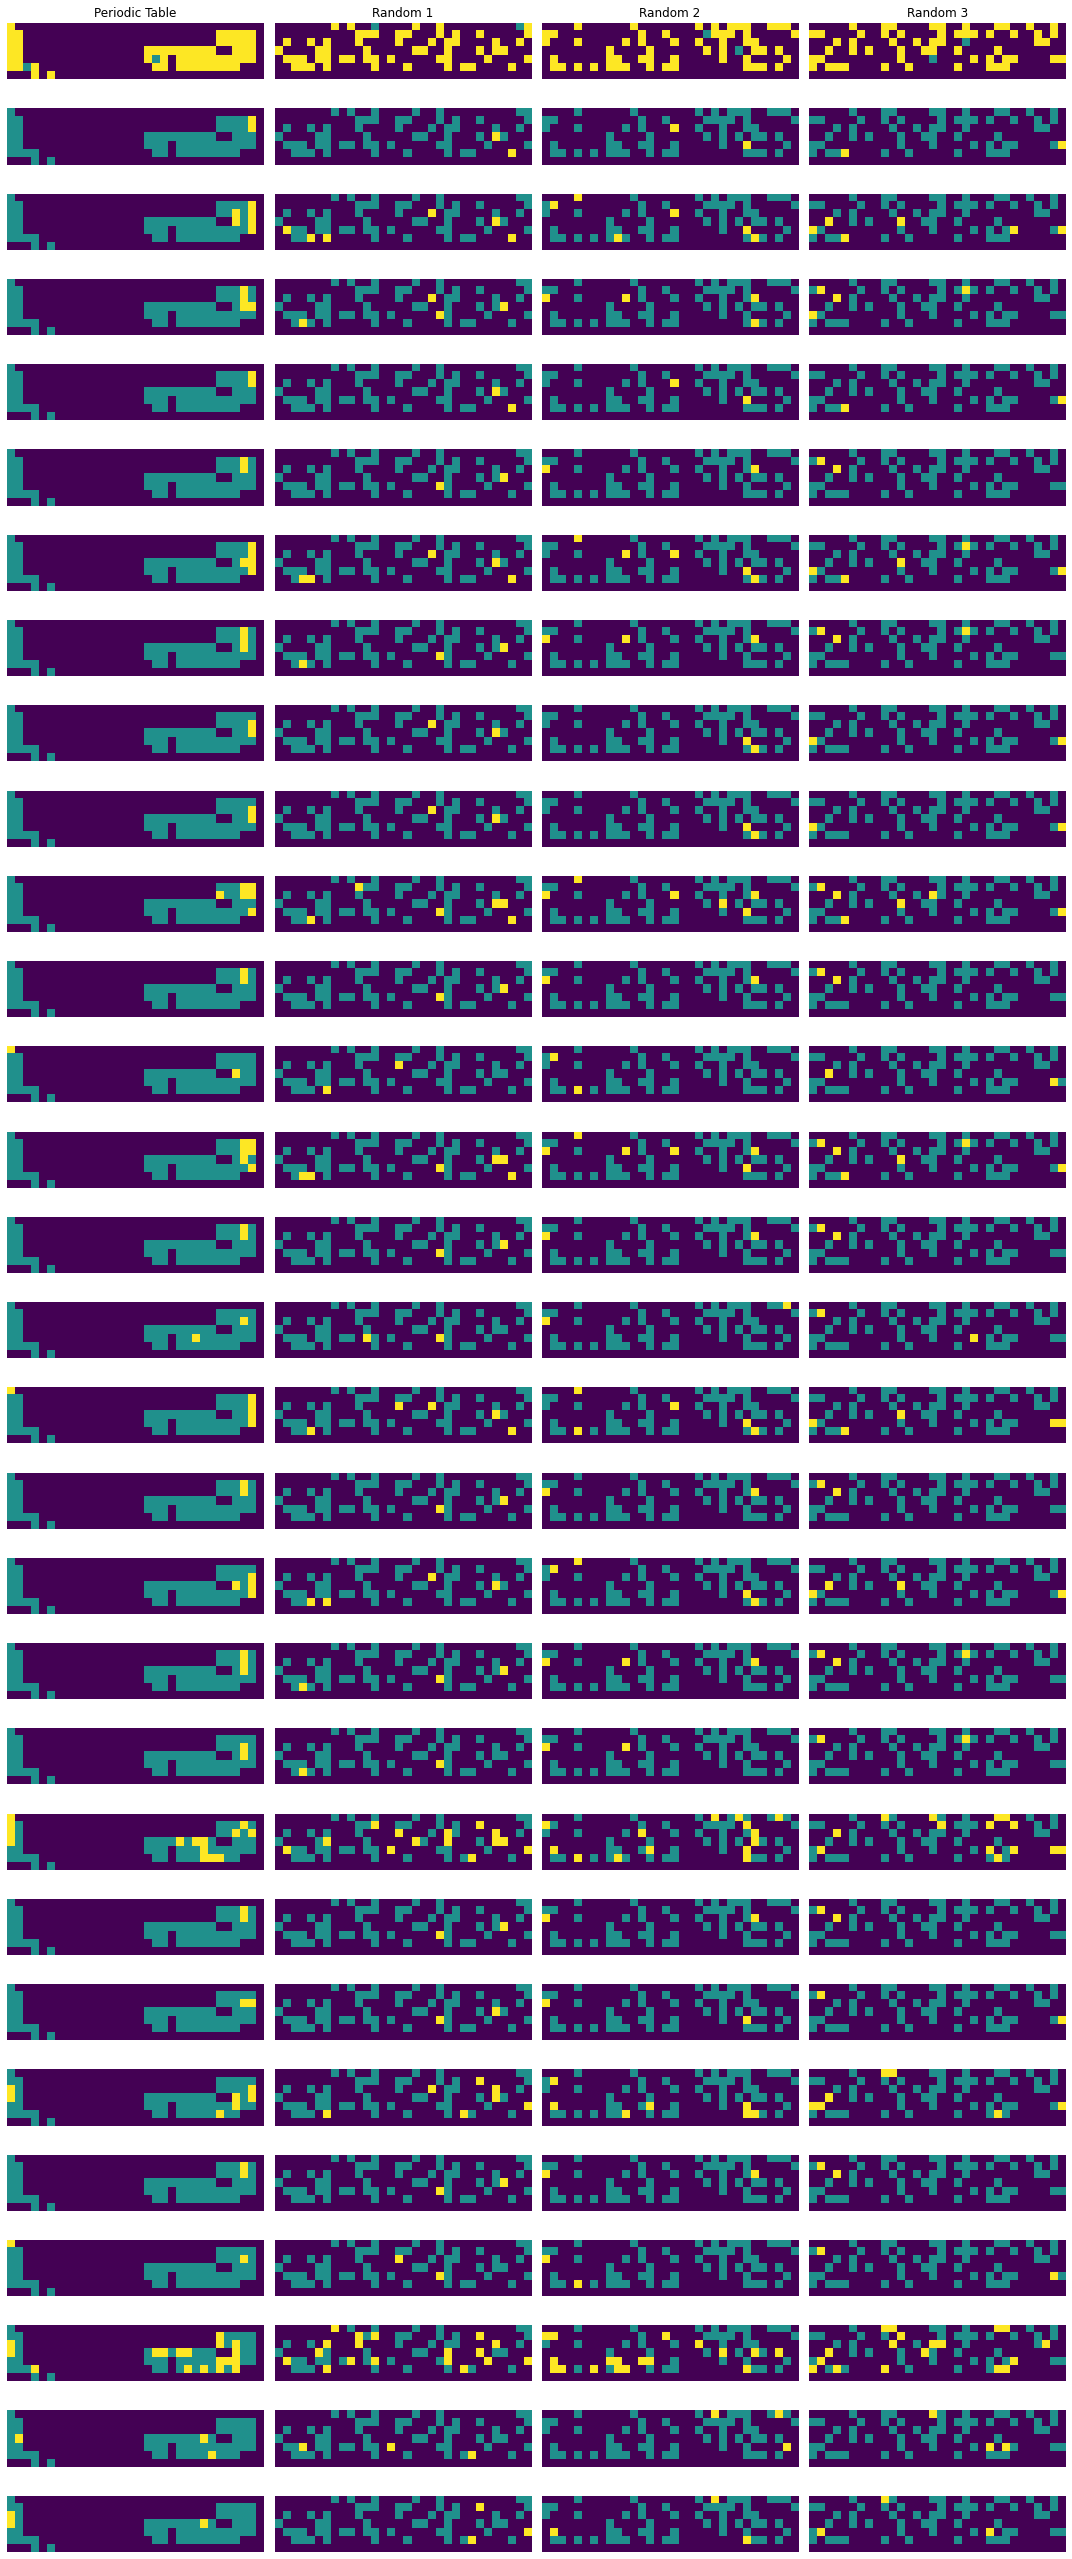

In [235]:
# Load original TP with which this data was created (TP)
from TPs import TP

reprs = [t]
for i in range(3):
    TPrand = getRandPT(TP)
    randTP = translate(t,TP,TPrand)
    reprs.append(randTP)

N = 30
fig,ax = plt.subplots(N,4,figsize=(15,6*N/5))

ax[0,0].set_title('Periodic Table')
ax[0,1].set_title('Random 1')
ax[0,2].set_title('Random 2')
ax[0,3].set_title('Random 3')

for i in range(N):
    for j in range(4):
        ax[i,j].imshow(reprs[j][i])
        ax[i,j].axis('off')
plt.tight_layout()

### This functionality will allow for the production and evaluation of different periodic systems. This also implies for instance optimization, among other posibilities.

---

Let's now see about how many possible PTs we got.

In [1]:
from itertools import permutations
from math import factorial
import numpy as np

N is the total number of different possible positions. e.g. 32*7=224 for long PT

n is the number of elements. e.g. 60 in 1868

### No. unique configurations not keeping order:

\begin{equation}
\frac{N!}{(N-n)!}
\end{equation}

### No. configurations keeping order but not unique:

\begin{equation}
\frac{N!}{n!}
\end{equation}

### No. unique configurations and keeping order:

\begin{equation}
\frac{N!}{(N-n)!n!}
\end{equation}

In [3]:
N = 9     # Numero de posiciones (32*7 para PT)
n = 4     # Numero de elementos (1,2,3,4,...)

zeros = [0]*(N-n) 
unique_elems = [i for i in range(1,n+1)]

perms = np.array(list(permutations(zeros + unique_elems)))

# Según formula, es:

print("No. unique configurations not keeping order:\t",int(factorial(N)/(factorial(N-n))))

print("No. configurations keeping order but not unique:",int(factorial(N)/(factorial(n))))

print("No. unique configurations and keeping order:\t",int(factorial(N)/(factorial(N-n)*factorial(n))))

No. unique configurations not keeping order:	 3024
No. configurations keeping order but not unique: 15120
No. unique configurations and keeping order:	 126


In [4]:
#No. unique configurations not keeping order
a = np.unique(perms,axis=0)   # Take only unique permutations (that is, make all zeros equal)
a.shape[0]

3024

In [5]:
condition = True
for i in unique_elems[:-1]:
    tmp_i = (perms == i).nonzero()[1]  # Get index of element i in permutation
    tmp_i_1 = (perms == i+1).nonzero()[1]  # Get index of element i+1 in permutation
    
    condition = condition & (tmp_i < tmp_i_1)
    
#No. configurations keeping order but not unique
a = perms[condition]
a.shape[0]

15120

In [13]:
uniqs = np.unique(a,axis=0)
uniqs.shape[0]

126

In [14]:
import sys
np.set_printoptions(threshold=sys.maxsize)

uniqs[0:30]

array([[0, 0, 0, 0, 0, 1, 2, 3, 4],
       [0, 0, 0, 0, 1, 0, 2, 3, 4],
       [0, 0, 0, 0, 1, 2, 0, 3, 4],
       [0, 0, 0, 0, 1, 2, 3, 0, 4],
       [0, 0, 0, 0, 1, 2, 3, 4, 0],
       [0, 0, 0, 1, 0, 0, 2, 3, 4],
       [0, 0, 0, 1, 0, 2, 0, 3, 4],
       [0, 0, 0, 1, 0, 2, 3, 0, 4],
       [0, 0, 0, 1, 0, 2, 3, 4, 0],
       [0, 0, 0, 1, 2, 0, 0, 3, 4],
       [0, 0, 0, 1, 2, 0, 3, 0, 4],
       [0, 0, 0, 1, 2, 0, 3, 4, 0],
       [0, 0, 0, 1, 2, 3, 0, 0, 4],
       [0, 0, 0, 1, 2, 3, 0, 4, 0],
       [0, 0, 0, 1, 2, 3, 4, 0, 0],
       [0, 0, 1, 0, 0, 0, 2, 3, 4],
       [0, 0, 1, 0, 0, 2, 0, 3, 4],
       [0, 0, 1, 0, 0, 2, 3, 0, 4],
       [0, 0, 1, 0, 0, 2, 3, 4, 0],
       [0, 0, 1, 0, 2, 0, 0, 3, 4],
       [0, 0, 1, 0, 2, 0, 3, 0, 4],
       [0, 0, 1, 0, 2, 0, 3, 4, 0],
       [0, 0, 1, 0, 2, 3, 0, 0, 4],
       [0, 0, 1, 0, 2, 3, 0, 4, 0],
       [0, 0, 1, 0, 2, 3, 4, 0, 0],
       [0, 0, 1, 2, 0, 0, 0, 3, 4],
       [0, 0, 1, 2, 0, 0, 3, 0, 4],
       [0, 0, 1, 2, 0, 0, 3,

In [18]:
i=100

print(uniqs[i])
print()
print(uniqs[i].reshape(3,3))

[1 0 2 3 0 0 0 0 4]

[[1 0 2]
 [3 0 0]
 [0 0 4]]


## That said, how many different possible PTs exist where the order is preserved?

In [32]:
N = 30*7     # Numero de posiciones (32*7)
n = 60     # Numero de elementos (1,2,3,4,...)

print("No. unique configurations not keeping order:\t",factorial(N)/(factorial(N-n)))

#print("No. configurations keeping order but not unique:",factorial(N)//(factorial(n)))

print("No. unique configurations and keeping order:\t",factorial(N)/(factorial(N-n)*factorial(n)))

print(f"\nDifference is a factor of:\t\t\t {factorial(n):.15e}")

No. unique configurations not keeping order:	 1.8522056472827472e+135
No. unique configurations and keeping order:	 2.225944617131523e+53

Difference is a factor of:			 8.320987112741390e+81
